In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
def generate_synthetic_data(n_samples=1000):
    np.random.seed(42)
    
    # Ana özellikler
    feature_1 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_2 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_3 = np.random.uniform(low=-2, high=2, size=n_samples)
    feature_4 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_5 = np.random.normal(loc=0, scale=1, size=n_samples)
    
    # Hedef değişkeni oluştur (çeşitli gizli etkileşimlerle ve koşullu durumlarla)
    target = (
        0.5 * np.where(feature_1 > 0, feature_2, -feature_2) +  # Koşullu etkileşim: feature_1 > 0 olunca feature_2 pozitif etkiliyor, aksi halde negatif
        0.3 * np.maximum(feature_2, feature_3) +  # En büyük olan feature'ı seçip pozitif etki veriyoruz
        #-0.5 * np.where(feature_3 > 0, (feature_4)**2, feature_4) +  # feature_3 > 1 olunca feature_1'in karesi negatif etki yapıyor, aksi halde mutlak değer alınıyor
        #-0.5 * (feature_4 * feature_5) + 
        0.2 * (feature_4) ** 2 + 
        np.random.normal(loc=0, scale=0.1, size=n_samples)  # Gürültü ekleyelim
    )
    
    # Hedef değişkeni ikili sınıflandırma için dönüştür
    target_binary = (target > target.mean()).astype(int)
    
    # DataFrame oluştur
    df = pd.DataFrame({
        'feature_1': feature_1,
        'feature_2': feature_2,
        'feature_3': feature_3,
        'feature_4': feature_4,
        'feature_5': feature_5,
        'target': target_binary
    })
    
    return df

# Veri setini oluştur
df = generate_synthetic_data(n_samples=1000)

# Eğitim ve test setlerine ayır
X = df.drop('target', axis=1).values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "max_depth": 4,
    "feature_fraction": 0.9,
}

# Train the model
num_round = 100
model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 350, number of negative: 450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437500 -> initscore=-0.251314
[LightGBM] [Info] Start training from score -0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

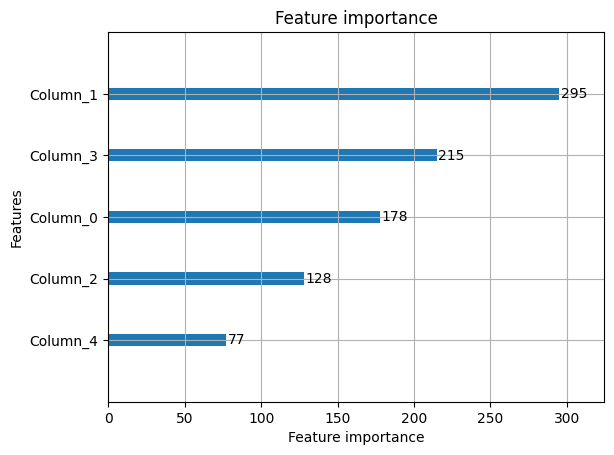

In [4]:
lgb.plot_importance(model)

In [5]:
from explainer import Tree
from plots import plot_bar, plot_values_points, plot_dependecy, plot_points

In [6]:
tree = Tree(model, X_train)
tree.analyze_tree()

In [7]:
i = 0
values, raw_score = tree.analyze_row(X_train[[i], :], detailed=False)

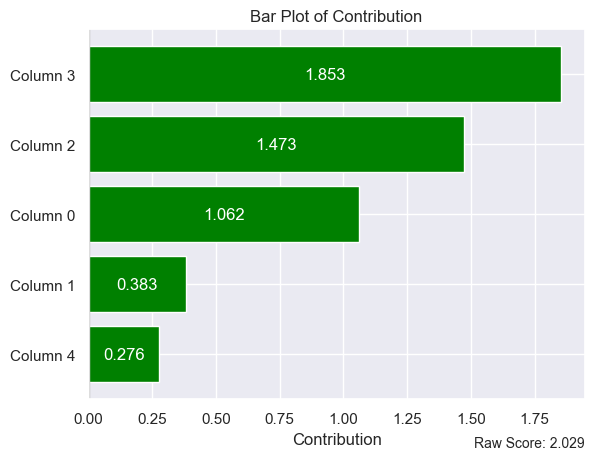

In [8]:
plot_bar(values, raw_score)

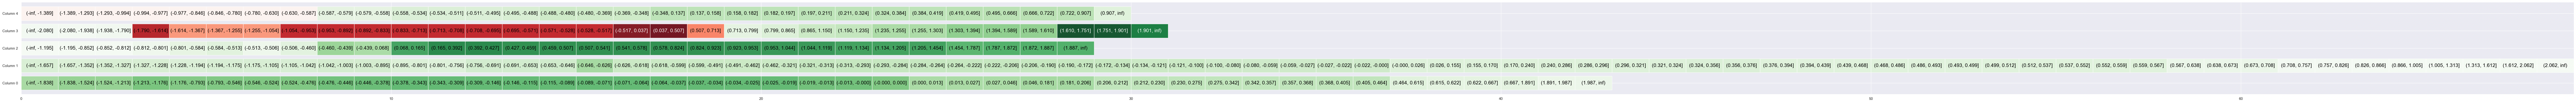

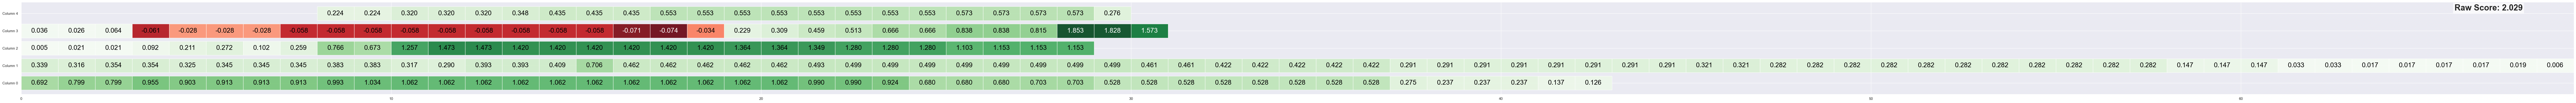

In [9]:
values, points, raw_score = tree.analyze_row(X_train[[i], :])

plot_points(values, points)

plot_values_points(values, raw_score, points)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


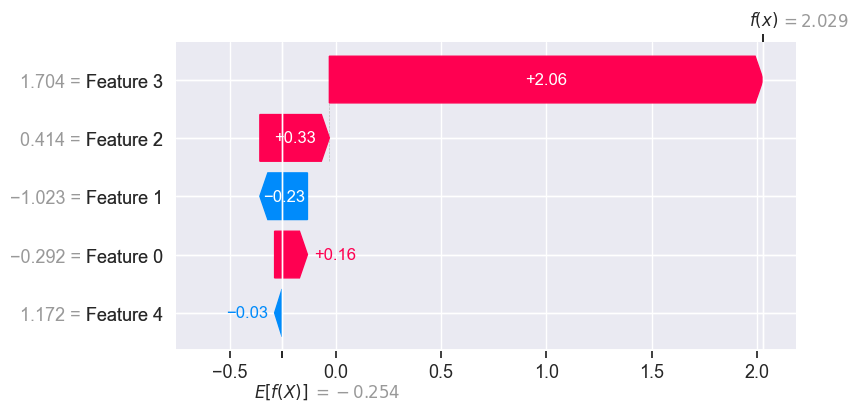

In [10]:
import shap
explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_train)

shap.waterfall_plot(shap_values[i], 20)

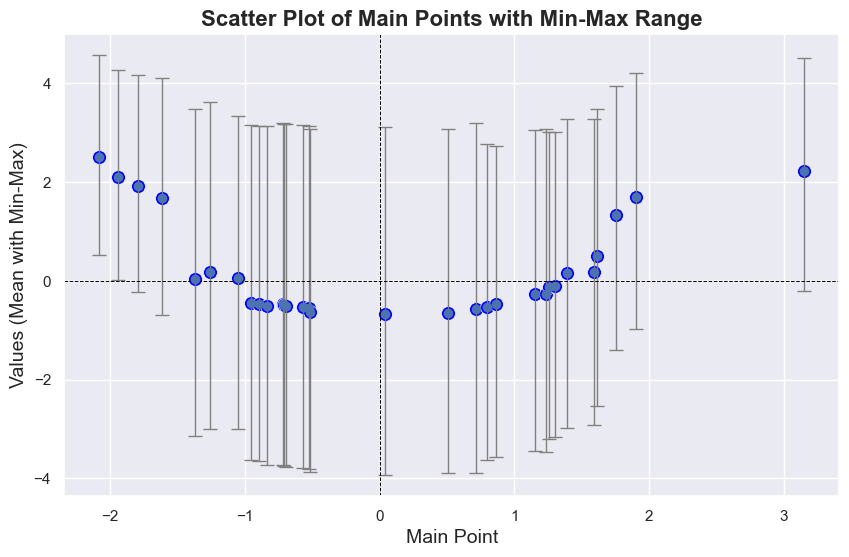

In [11]:
df = tree.analyze_feature_v2(3)

# Scatter plot ve min-max aralığını gösteren hata çubukları
plt.figure(figsize=(10, 6))

# Ortalamalar için scatter plot
sns.scatterplot(data=df, x='main_point', y='mean', color='blue', s=100, edgecolor='w', linewidth=0.5)

# Min-max aralığı için errorbar (hata çubukları)
plt.errorbar(df['main_point'], df['mean'], yerr=[df['mean'] - df['min'], df['max'] - df['mean']], 
             fmt='o', ecolor='gray', capsize=5, elinewidth=1, capthick=1)

# Eksenler, başlık ve ızgara
plt.title('Scatter Plot of Main Points with Min-Max Range', fontsize=16, fontweight='bold')
plt.xlabel('Main Point', fontsize=14)
plt.ylabel('Values (Mean with Min-Max)', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)  # Y ekseninde sıfır çizgisi
plt.axvline(0, color='black', linestyle='--', linewidth=0.7)  # X ekseninde sıfır çizgisi
plt.grid(True)

# Göster
plt.show()


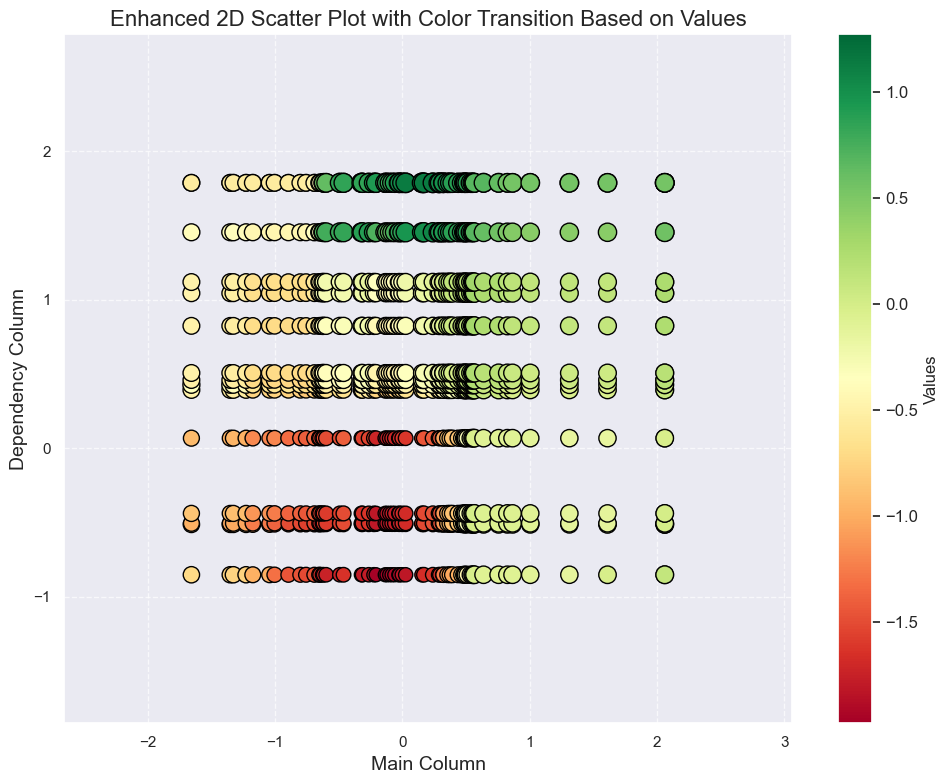

In [12]:
df = tree.analyze_dependency(1,2)
plot_dependecy(df)

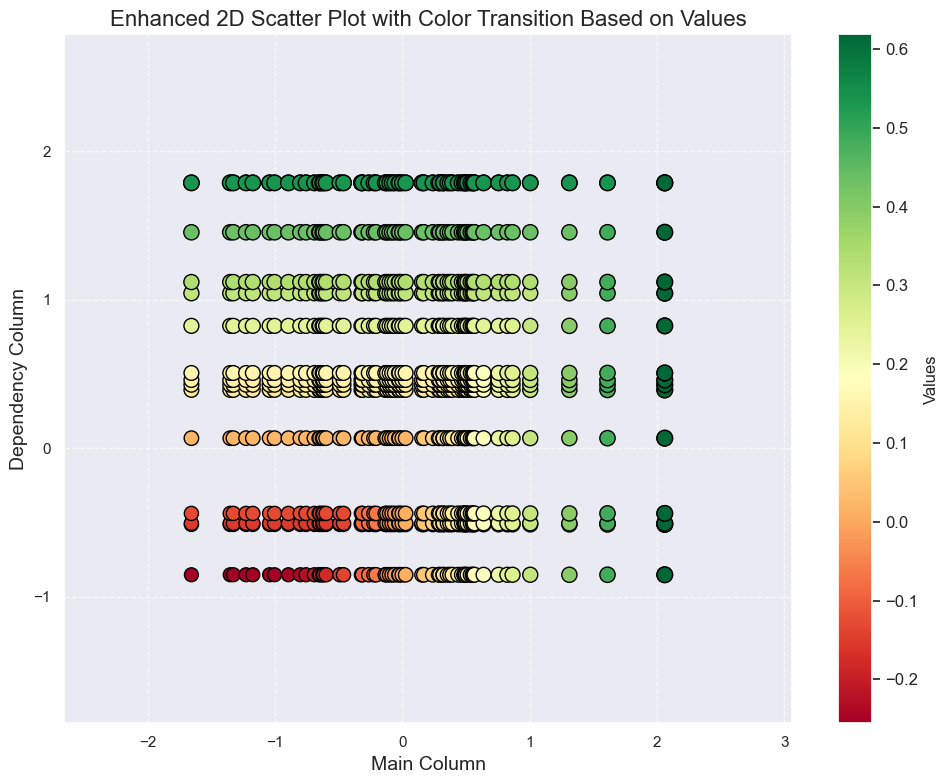

In [13]:
df["values"] = 0.3 * np.maximum(df["main_point"], df["sub_point"])

plot_dependecy(df)

In [18]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)


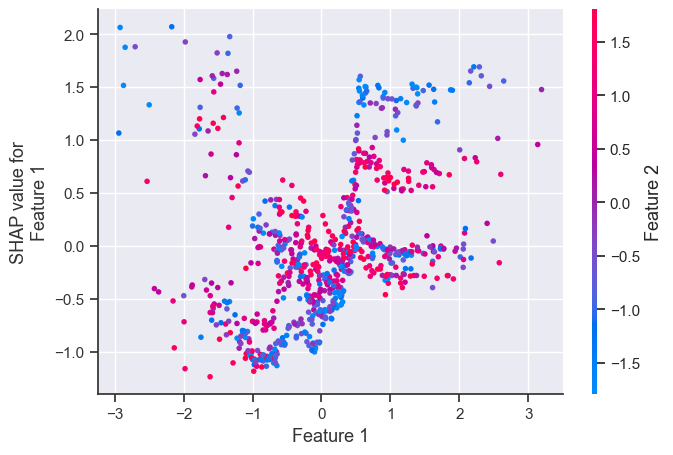

In [19]:

shap.dependence_plot(1, shap_values.values, X_train, interaction_index=2)

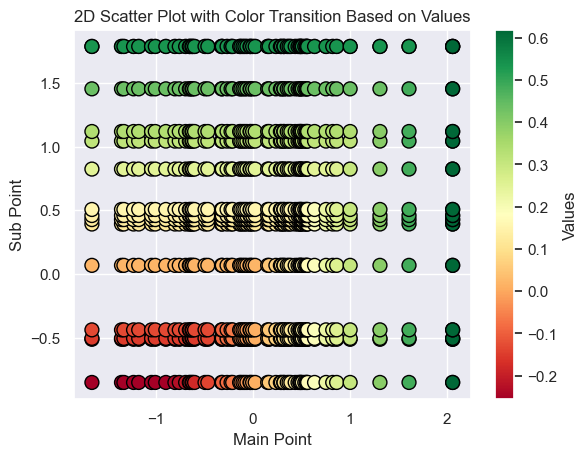

In [16]:
#df["values"] = -0.4 * np.where(df["sub_point"] > 1, df["main_point"]**2, np.abs(df["main_point"]))

df["values"]  = 0.3 * np.maximum( df["main_point"],  df["sub_point"])
# Renkleri values ile orantılı olarak dinamik ayarlamak
scatter = plt.scatter(
    x=df['main_point'], 
    y=df['sub_point'], 
    c=df['values'],  # Renkler values sütununa göre
    cmap='RdYlGn',   # Kırmızıdan yeşile geçiş (negatiften pozitife)
    s=100,  # Nokta boyutu
    edgecolor='black'  # Noktaların kenar rengi
)

# Colorbar ekleme
plt.colorbar(scatter, label='Values')

# Eksen başlıkları
plt.xlabel('Main Point')
plt.ylabel('Sub Point')

plt.title('2D Scatter Plot with Color Transition Based on Values')
plt.show()

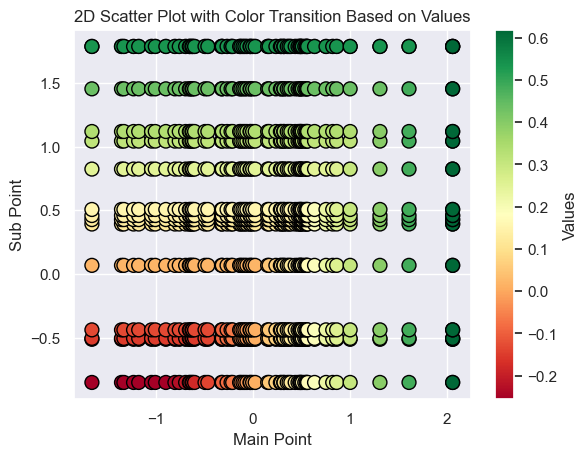

In [17]:
# Renkleri values ile orantılı olarak dinamik ayarlamak
scatter = plt.scatter(
    x=df['main_point'], 
    y=df['sub_point'], 
    c=df['values'],  # Renkler values sütununa göre
    cmap='RdYlGn',   # Kırmızıdan yeşile geçiş (negatiften pozitife)
    s=100,  # Nokta boyutu
    edgecolor='black'  # Noktaların kenar rengi
)

# Colorbar ekleme
plt.colorbar(scatter, label='Values')

# Eksen başlıkları
plt.xlabel('Main Point')
plt.ylabel('Sub Point')

plt.title('2D Scatter Plot with Color Transition Based on Values')
plt.show()